In [574]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer, Binarizer
from sklearn.preprocessing import FunctionTransformer as FT
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree

from sklearn.model_selection import train_test_split

### Import & Split

In [549]:
X = pd.read_csv("/home/jorge/Proyectos/datas/titanic/tables/data_cleaned/train.csv")
Y = X["Survived"]
del X["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, Y)

### Model

In [550]:
##### Fill nans age
def fillage(X):
    mean = np.nanmean(X)
    return np.nan_to_num(X, nan=mean)

### Cut Sibps
def cutsip(X):
    hasmap = {
        0: 0,
        1: 1, 
        2: 2,
        3: 2, 
        4: 2,
        5: 2, 
        8: 2 
    }
    DX = pd.DataFrame(X, columns=["X"])
    return DX.apply(lambda x: hasmap[x]).values
# Cabin
## Letter
def get_letters1(x):
    if isinstance(x, float) == True:
        return ("None")
    sx = x.split()
    return sx[0][0]
def get_letters2(x):
    if isinstance(x, float) == True:
        return 0
    else: 
        return 1

def gletter(X):
    return np.vectorize(get_letters2)(X)

## Number
def get_number(x):
    if isinstance(x, float) == True:
        return 500
    sx = x.split()

    if len(sx[0][1:]) == 0:
        Number = 500
    else:
        Number = int(sx[0][1:])
    return Number

def gnumber(X):
    return np.vectorize(get_number)(X)

## Many
def get_many(x):
    if isinstance(x, float) == True:
        return 0
    sx = x.split()
    if len(sx)>1:
        return 1
    else:
        return 0

def gmany(X):
    return np.vectorize(get_many)(X)

In [561]:
column_transforms_initial_CT = [
    ("sex2binary", OrdinalEncoder(dtype="int"), ["Sex"]),
    ("age_inpute", SimpleImputer(strategy="mean"), ["Age"]),
    ("pclass", "passthrough", ["Pclass"]),
    #("fare", "passthrough", ["Fare"]),
    ("parch", "passthrough", ["Parch"]),
    ("letter", FT(gletter), ["Cabin"]),
    ("number", FT(gnumber), ["Cabin"]),
    ("many", FT(gmany), ["Cabin"])
    #("sibsp", "passthrough", ["SibSp"]),
    #("Parch", Binarizer(), ["Parch"]),
    #("sibsp", KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="quantile"), ["SibSp"]),
    #("age_inpute", SimpleImputer(strategy="mean"), ["Age"])
    
]

column_transforms_final_CT = [
    ("sex", "passthrough", [0]),
    ("age", "passthrough", [1]),
    ("pclass", OneHotEncoder(dtype="int"), [2]),
    ("parch", "passthrough", [3]),
    #("letter", OneHotEncoder(dtype="int"), [4])
    ("letter", "passthrough", [4]),
    ("number", "passthrough", [5]),
    ("many", "passthrough", [6])
    #("sibsp", OneHotEncoder(dtype="int"), [2])
]
inital_CT = ColumnTransformer(column_transforms_initial_CT, remainder="drop", verbose=True)
final_CT = ColumnTransformer(column_transforms_final_CT, remainder="drop", verbose=True)

### Classifiers

GB = [
    ("Initial transform", inital_CT), #type of columns and a littel clear
    ("Final transform", final_CT), #One hot encoder all labels
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=150, max_depth=4, learning_rate=0.01))
]

RF = [
    ("Initial transform", inital_CT), #type of columns and a littel clear
    ("Final transform", final_CT), #One hot encoder all labels
    ("Random Forest", RandomForestClassifier(n_estimators=150, max_depth=5, criterion="entropy"))
]

DT = [
    ("Initial transform", inital_CT), #type of columns and a littel clear
    ("Final transform", final_CT), #One hot encoder all labels
    ("Decision Tree", DecisionTreeClassifier(criterion="gini", max_depth=4, splitter="random"))
]

model = Pipeline(DT, verbose=True)

### Train & Test

In [564]:
f = model.fit(X_train, y_train)

[ColumnTransformer] .... (1 of 7) Processing sex2binary, total=   0.0s
[ColumnTransformer] .... (2 of 7) Processing age_inpute, total=   0.0s
[ColumnTransformer] ........ (3 of 7) Processing pclass, total=   0.0s
[ColumnTransformer] ......... (4 of 7) Processing parch, total=   0.0s
[ColumnTransformer] ........ (5 of 7) Processing letter, total=   0.0s
[ColumnTransformer] ........ (6 of 7) Processing number, total=   0.0s
[ColumnTransformer] .......... (7 of 7) Processing many, total=   0.0s
[Pipeline] . (step 1 of 3) Processing Initial transform, total=   0.0s
[ColumnTransformer] ........... (1 of 7) Processing sex, total=   0.0s
[ColumnTransformer] ........... (2 of 7) Processing age, total=   0.0s
[ColumnTransformer] ........ (3 of 7) Processing pclass, total=   0.0s
[ColumnTransformer] ......... (4 of 7) Processing parch, total=   0.0s
[ColumnTransformer] ........ (5 of 7) Processing letter, total=   0.0s
[ColumnTransformer] ........ (6 of 7) Processing number, total=   0.0s
[Colum

In [565]:
model.score(X_test, y_test)

0.820627802690583

### DataSet

In [554]:
muestra = model[:-1].fit_transform(X_train, y_train)

[ColumnTransformer] .... (1 of 7) Processing sex2binary, total=   0.0s
[ColumnTransformer] .... (2 of 7) Processing age_inpute, total=   0.0s
[ColumnTransformer] ........ (3 of 7) Processing pclass, total=   0.0s
[ColumnTransformer] ......... (4 of 7) Processing parch, total=   0.0s
[ColumnTransformer] ........ (5 of 7) Processing letter, total=   0.0s
[ColumnTransformer] ........ (6 of 7) Processing number, total=   0.0s
[ColumnTransformer] .......... (7 of 7) Processing many, total=   0.0s
[ColumnTransformer] ........... (1 of 7) Processing sex, total=   0.0s
[ColumnTransformer] ........... (2 of 7) Processing age, total=   0.0s
[ColumnTransformer] ........ (3 of 7) Processing pclass, total=   0.0s
[ColumnTransformer] ......... (4 of 7) Processing parch, total=   0.0s
[ColumnTransformer] ........ (5 of 7) Processing letter, total=   0.0s
[ColumnTransformer] ........ (6 of 7) Processing number, total=   0.0s
[ColumnTransformer] .......... (7 of 7) Processing many, total=   0.0s


In [555]:
M = pd.DataFrame(muestra, columns=["sex", "age", "pc1", "pc2", "pc3", "parch", "letter", "number", "many"])
M["Y"] = y_train
M.corr()

,sex,age,pc1,pc2,pc3,parch,letter,number,many,Y
sex,1.000000,0.058557,-0.103486,-0.070122,0.144851,-0.215208,-0.140675,0.152083,-0.030492,-0.057716
age,0.058557,1.000000,0.322960,0.009836,-0.283123,-0.200735,0.232575,-0.230453,-0.018271,0.005559
pc1,-0.103486,0.322960,1.000000,-0.275352,-0.629474,-0.023508,0.780554,-0.794256,0.247278,0.027745
pc2,-0.070122,0.009836,-0.275352,1.000000,-0.573657,0.002274,-0.150628,0.158239,-0.085711,0.018218
pc3,0.144851,-0.283123,-0.629474,-0.573657,1.000000,0.018192,-0.543309,0.548832,-0.141412,-0.038292
parch,-0.215208,-0.200735,-0.023508,0.002274,0.018192,1.000000,0.032160,-0.046024,0.206364,-0.039585
letter,-0.140675,0.232575,0.780554,-0.150628,-0.543309,0.032160,1.000000,-0.974156,0.329309,0.044880
number,0.152083,-0.230453,-0.794256,0.158239,0.548832,-0.046024,-0.974156,1.000000,-0.268958,-0.046797
many,-0.030492,-0.018271,0.247278,-0.085711,-0.141412,0.206364,0.329309,-0.268958,1.000000,-0.035833
Y,-0.057716,0.005559,0.027745,0.018218,-0.038292,-0.039585,0.044880,-0.046797,-0.035833,1.000000


### Eval

In [556]:
model[-1].feature_importances_

array([0.59899784, 0.10804983, 0.0073024 , 0.01347232, 0.17251753,
       0.01764467, 0.        , 0.08201541, 0.        ])

In [586]:
M.columns.tolist()

['sex', 'age', 'pc1', 'pc2', 'pc3', 'parch', 'letter', 'number', 'many', 'Y']

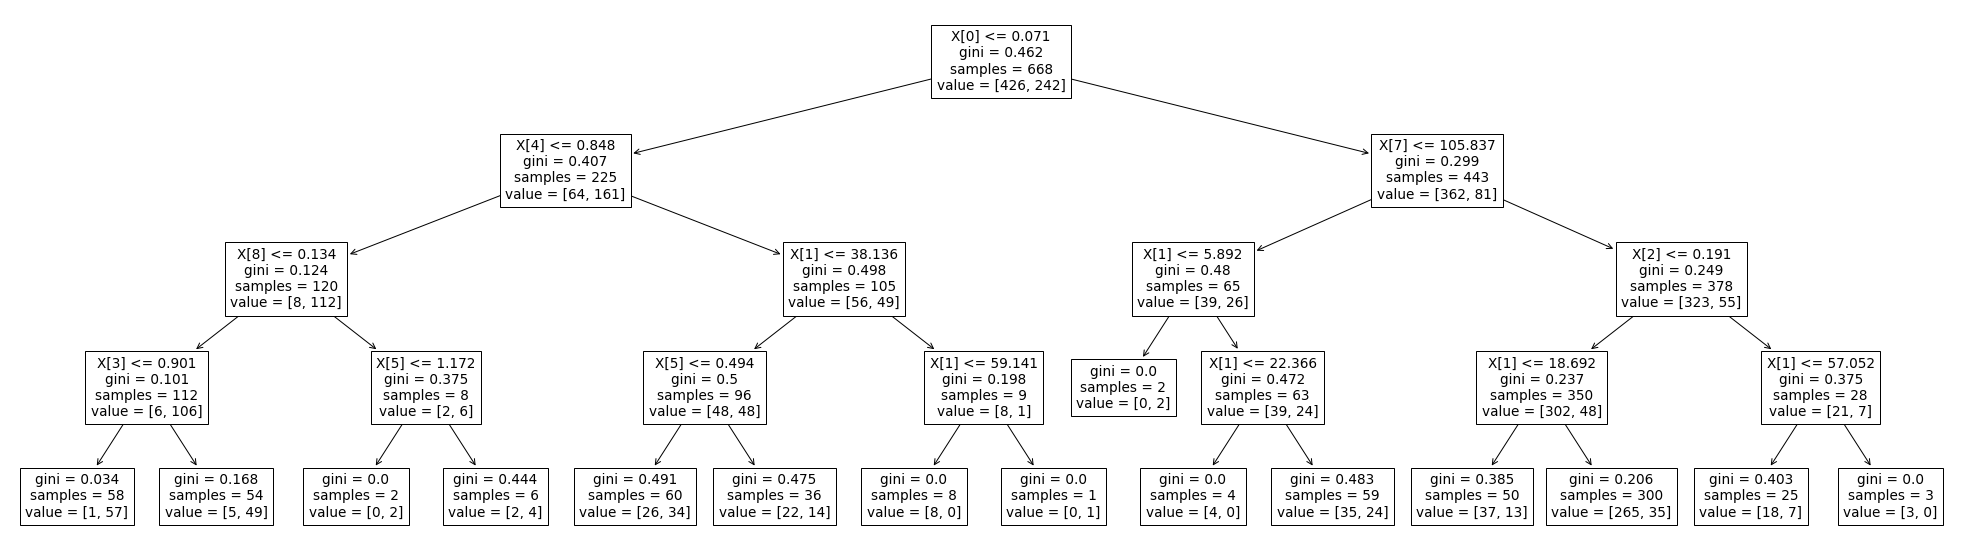

In [585]:
fig, ax = plt.subplots(figsize=(35,10))
plot_tree(model[-1], ax=ax)
plt.show()

### Predict

In [558]:
stop

NameError: name 'stop' is not defined

In [559]:
P = pd.read_csv("/home/jorge/Proyectos/datas/titanic/tables/data_cleaned/test.csv")
P

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [560]:
Predicted = pd.Series(model.predict(P))

Submission = pd.DataFrame({
    "PassengerId": P["PassengerId"],
    "Survived": Predicted
})

Submission.to_csv("/home/jorge/Proyectos/datas/titanic/tables/submission.csv", index=False)